In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset

In [4]:
os.chdir("c:/Users/victo/Personal_Projects/spirometry/")
os.getcwd()

'c:\\Users\\victo\\Personal_Projects\\spirometry'

In [5]:
spirometry = pd.read_csv('spirometry_data/spirotidydatafinal.txt', sep=',')

In [6]:
# spirometry.dropna(inplace=True)
spirometry.head()

,ID,Visit,Trial,Time,Volume,Flow
0,101,1,1,0.0,1.6822,0.04125
1,101,1,1,10.0,1.6829,0.07125
2,101,1,1,20.0,1.6840,0.11250
3,101,1,1,30.0,1.6855,0.14750
4,101,1,1,40.0,1.6872,0.16812


In [7]:
os.getcwd()

'c:\\Users\\victo\\Personal_Projects\\spirometry'

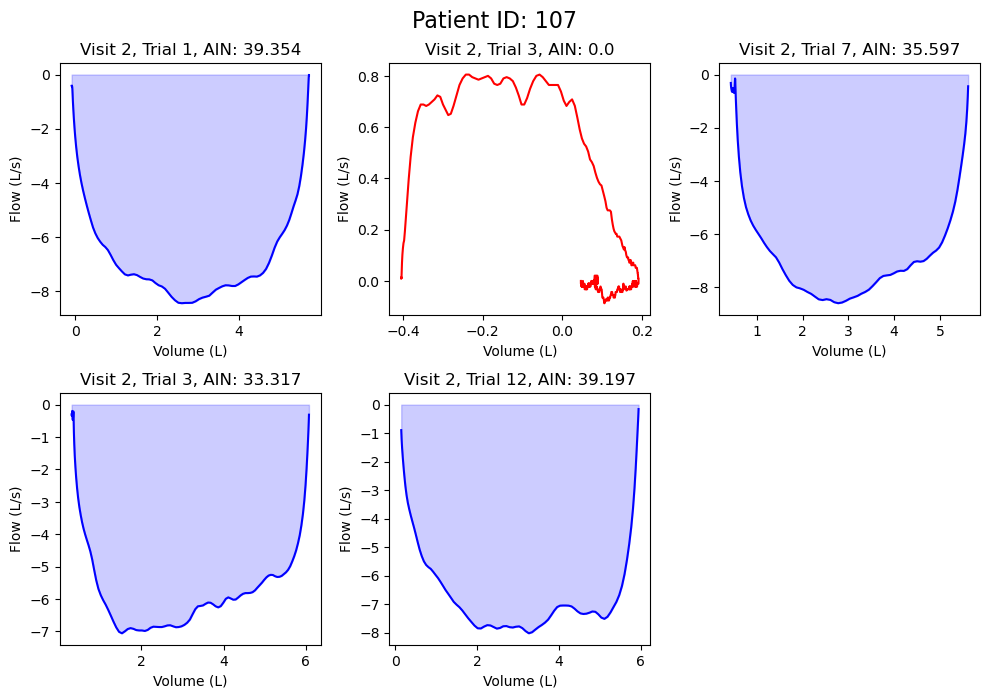

In [102]:
spirometry = spirometry[(spirometry['ID'] == 107)]
patient_ids = spirometry['ID'].unique()

for patient_id in patient_ids:
    # Create a directory for each patient
    if not os.path.exists(f'spirometry_data/ID{patient_id}'):
        os.makedirs(f'spirometry_data/ID{patient_id}')
    
    # Format the data for each patient
    patient_data = spirometry[spirometry['ID'] == patient_id]

    accepted_flow, accepted_volume = pd.DataFrame(), pd.DataFrame()
    trials_array, visits_array = np.array([]), np.array([])
    
    # Get the number of visits each patient
    n_visits = patient_data['Visit'].unique()    
    for visit in n_visits:
        visit_data = patient_data[patient_data['Visit'] == visit]
        n_trials = patient_data[patient_data['Visit'] == visit]['Trial'].unique()
        for trial in n_trials:
            visits_array = np.append(visits_array, visit)
            trials_array = np.append(trials_array, trial)
            
            # Creating Volume and Flow arrays for each trial
            vol_trex = visit_data[visit_data['Trial'] == trial]['Volume']
            flow_trex = visit_data[visit_data['Trial'] == trial]['Flow']
            accepted_flow = pd.concat([accepted_flow, flow_trex.reset_index(drop=True)], axis=1)
            accepted_volume = pd.concat([accepted_volume, vol_trex.reset_index(drop=True)], axis=1)
            
    accepted_flow = accepted_flow.T
    accepted_volume = accepted_volume.T
    subplot_size = int(np.ceil(np.sqrt(len(trials_array))))
    fig, axs = plt.subplots(subplot_size, subplot_size, figsize=(10, 10))
    fig.suptitle(f"Patient ID: {patient_id}", fontsize=16)
    m = 0
    
    # Calculate AIN 
    AIN = np.array([])

    visits_array = visits_array.astype(int)
    trials_array = trials_array.astype(int)

    for i, trial in enumerate(trials_array):
        axs = axs.flatten()
        vol_ain = accepted_volume.iloc[i].to_numpy().reshape(1, -1)
        flow_ain = accepted_flow.iloc[i].to_numpy().reshape(1, -1)
        m += 1
        # Finding peak of inspiratory (since inspiratory flow is negative, 
        # we use the minimum value of flow as the peak of inspiratory flow)
        min_flow, min_flow_idx = np.nanmin(flow_ain, axis=1), np.nanargmin(flow_ain, axis=1)[0]
        
        # Finding the maximum volume and its index
        max_vol, max_vol_idx = np.nanmax(vol_ain), np.nanargmax(vol_ain, axis=1)[0]
        
        # Find the 2nd index for ain calc (dont really understand this part)
        ain_val2_idx = np.where(flow_ain[0][min_flow_idx:] >= 0)[0]
        ain_val2 = np.ones(ain_val2_idx.shape)
        disqualify = False
        if abs(min_flow) > 1 and max_vol > 0.5:
            if len(ain_val2_idx) == 0 and len(ain_val2) == 0:
                if np.min(np.abs(flow_ain[0, min_flow_idx:])) > 0.5:
                    ain_val2 = np.NaN
                    ain_val2_idx = np.NaN
                    disqualify = True
                else:
                    ain_val2_idx = np.where(np.isnan(flow_ain[0, min_flow_idx:]))[0]
                    ain_val2 = np.ones(ain_val2_idx.shape)
                    ain_val2_idx = ain_val2_idx[0]
                    ain_val2 = ain_val2[0]
            else:
                ain_val2 = ain_val2[0]
                ain_val2_idx = ain_val2_idx[0]
                
            # End index of whole data
            ain_idx2 = ain_val2_idx + min_flow_idx - 2
            
            flip_flow_ain = np.flip(flow_ain)
            min_flow_idx_flip = len(flow_ain[0])-min_flow_idx-1
            
            ain_val1_idx_flip = np.where(flip_flow_ain[0, min_flow_idx_flip:] >= 0)[0]
            ain_val1_flip = np.ones(ain_val1_idx_flip.shape)
            ain_val1_flip=ain_val1_flip[0]
            ain_val1_idx_flip=ain_val1_idx_flip[0]-1
            ain_idx1 = len(flow_ain[0])-(ain_val1_idx_flip+min_flow_idx_flip)+2
        else:
            ain_idx1 = np.nan
            ain_idx2 = np.nan
        if disqualify:
            ain_idx1 = np.nan
            ain_idx2 = np.nan
        
        if ain_idx1 is np.nan and ain_idx2 is np.nan:
            neg_vol_ain = vol_ain[0]
            neg_flow_ain = flow_ain[0]
            AIN = np.append(AIN, 0)
            # plt.subplot(subplot_size, subplot_size, m)
            axs[i].plot(neg_vol_ain, neg_flow_ain, color='red')
            axs[i].set_title(f"Visit {visit}, Trial {trial}, AIN: {round(AIN[i], 3)}")
            axs[i].set_xlabel(f"Volume (L)")
            axs[i].set_ylabel(f"Flow (L/s)")
        else:
            neg_vol_ain = vol_ain[0][ain_idx1:ain_idx2]
            neg_flow_ain = flow_ain[0][ain_idx1:ain_idx2]
            AIN = np.append(AIN, np.trapz(neg_flow_ain, neg_vol_ain))
            axs[i].plot(neg_vol_ain, neg_flow_ain, color='blue')
            axs[i].fill_between(neg_vol_ain, neg_flow_ain, color='blue', alpha=0.2)
            axs[i].set_title(f"Visit {visit}, Trial {trial}, AIN: {round(AIN[i], 3)}")
            axs[i].set_xlabel(f"Volume (L)")
            axs[i].set_ylabel(f"Flow (L/s)")
            
    # Remove empty subplots
    axs = [fig.delaxes(ax) for ax in axs if not ax.has_data()]
    plt.tight_layout()
    plt.savefig(f'spirometry_data/ID{patient_id}/patient_{patient_id}_spirometry.png')

In [ ]:
patient107 = spirometry[spirometry['ID'] == 107]
patient107.to_csv('spirometry_data/patient107.csv', index=False)